# Exploring OpenAI V1 functionality

On 11.06.23 OpenAI released a number of new features, and along with it bumped their Python SDK to 1.0.0. This notebook shows off the new features and how to use them with LangChain.

In [2]:
# need openai>=1.1.0, langchain>=0.0.332, langchain-experimental>=0.0.39
!pip install -U openai langchain langchain-experimental

   ---------------------------------------- 0.0/219.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/219.9 kB ? eta -:--:--
   ----- --------------------------------- 30.7/219.9 kB 325.1 kB/s eta 0:00:01
   ---------- ---------------------------- 61.4/219.9 kB 544.7 kB/s eta 0:00:01
   ------------------- ------------------ 112.6/219.9 kB 726.2 kB/s eta 0:00:01
   ------------------------------------- -- 204.8/219.9 kB 1.0 MB/s eta 0:00:01
   ---------------------------------------- 219.9/219.9 kB 1.0 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.1.2
    Uninstalling openai-1.1.2:
      Successfully uninstalled openai-1.1.2


In [2]:
from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage, SystemMessage

## [Vision](https://platform.openai.com/docs/guides/vision)

OpenAI released multi-modal models, which can take a sequence of text and images as input.

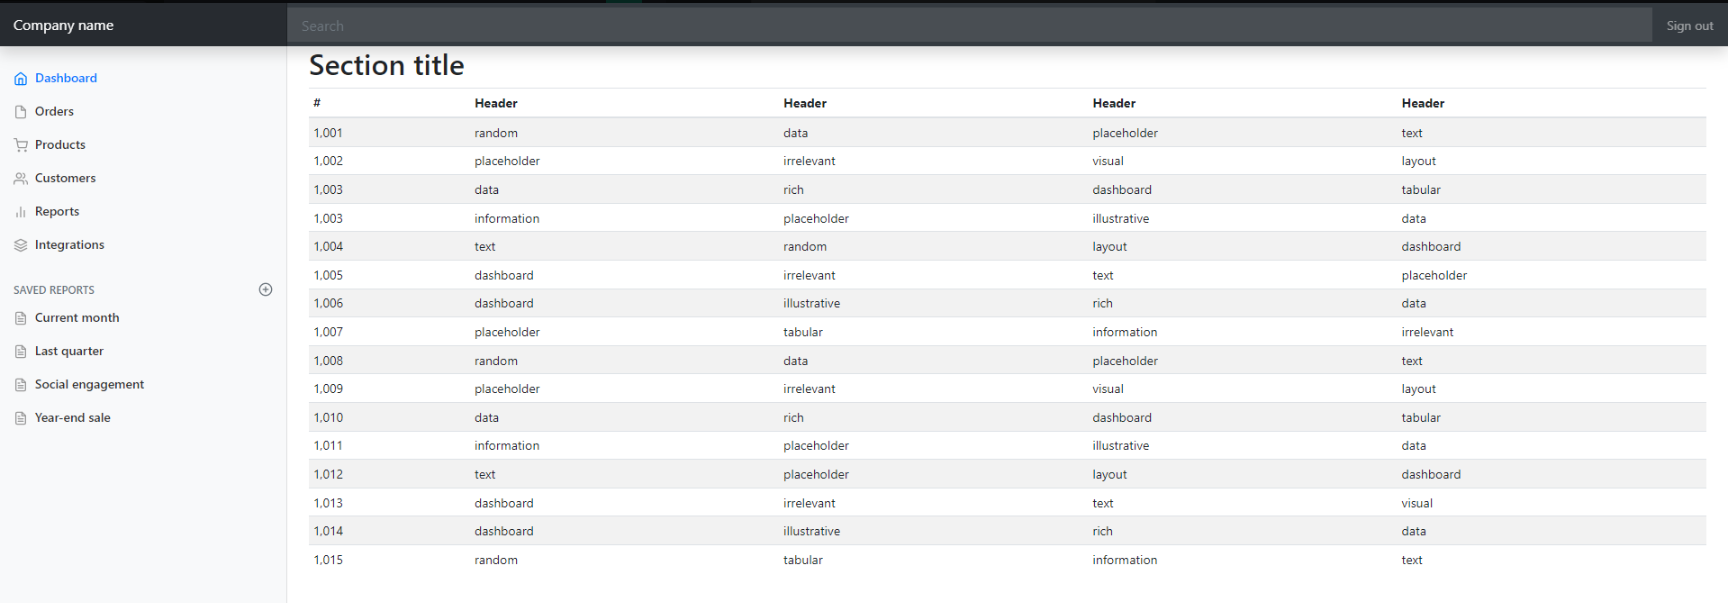

In [7]:
import base64
import requests

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')
    
# Path to your image
image_path = "images/bootstrap_app.png"

# Getting the base64 string
base64_image = encode_image(image_path)

# show image in notebook
from IPython.display import Image
Image(image_path)

In [37]:
chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=4096, temperature=0.6)

In [38]:


res = chat.invoke(
    [
        HumanMessage(
            content=[
                {"type": "text", "text": "What is this image showing"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                        "detail": "auto",
                    },
                },
            ]
        )
    ]
)

print(res.content)


This image shows a user interface of a web-based application or a content management system. The interface is designed in a clean and minimalistic style, with a navigation menu on the left side and a main content area on the right.

The navigation menu on the left includes options such as "Dashboard," "Orders," "Products," "Customers," "Reports," and "Integrations." There are also "SAVED REPORTS" with options like "Current month," "Last quarter," "Social engagement," and "Year-end sale."

The main content area on the right has a section titled "Section title" with a table or list view. The table contains columns with the headers "#," "Header," "Header," "Header," and "Header," suggesting that the column names are placeholders, and the content within the table is likely dummy or placeholder text used for design or development purposes. Each row has a number starting from 1,001 and contains various non-specific words like "random," "placeholder," "data," "information," and so on in the o

In [39]:
res = chat.invoke(
    [
        SystemMessage(
            content=[
                {"type": "text", "text": """You are a web developer. You are given an image and asked to create an html
                    page based on it. Be as accurate as possible to the image, even in the styles and colors. Use bootstrap framework v.5+ for generate the html. Use only cdn.jsdelivr.net for the scripts and do not use beta versions. 
                    Respond with html code only. Dont make comments in the response. Dont use markdown, only respond with html code"""},
            ]
        ),
        HumanMessage(
            content=[
                {"type": "text", "text": "Generate an html page based on this image."},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                        "detail": "auto",
                    },
                },
            ]
        )
    ]
)

# crea el html en un archivo con un nombre aleatorio y guardalo en el folder "html_files"
import os
from datetime import datetime
from random import randint

now = datetime.now()
timestamp = datetime.timestamp(now)
random_number = randint(0, 1000000)
filename = f"generated_html_files/{timestamp}_{random_number}.html"

# crea el archivo y escribe el contenido
f = open(filename, "w")
f.write(res.content.replace("```html", "").replace("```", ""))
f.close()

# abre el archivo en el browser
import webbrowser
webbrowser.open(f"file:///{os.getcwd()}/{filename}")


True

## [OpenAI assistants](https://platform.openai.com/docs/assistants/overview)

> The Assistants API allows you to build AI assistants within your own applications. An Assistant has instructions and can leverage models, tools, and knowledge to respond to user queries. The Assistants API currently supports three types of tools: Code Interpreter, Retrieval, and Function calling


You can interact with OpenAI Assistants using OpenAI tools or custom tools. When using exclusively OpenAI tools, you can just invoke the assistant directly and get final answers. When using custom tools, you can run the assistant and tool execution loop using the built-in AgentExecutor or easily write your own executor.

Below we show the different ways to interact with Assistants. As a simple example, let's build a math tutor that can write and run code.

### Using only OpenAI tools

In [ ]:
from langchain_experimental.openai_assistant import OpenAIAssistantRunnable

In [ ]:
interpreter_assistant = OpenAIAssistantRunnable.create_assistant(
    name="langchain assistant",
    instructions="You are a personal math tutor. Write and run code to answer math questions.",
    tools=[{"type": "code_interpreter"}],
    model="gpt-4-1106-preview",
)
output = interpreter_assistant.invoke({"content": "What's 10 - 4 raised to the 2.7"})
output

### As a LangChain agent with arbitrary tools

Now let's recreate this functionality using our own tools. For this example we'll use the [E2B sandbox runtime tool](https://e2b.dev/docs?ref=landing-page-get-started).

In [ ]:
!pip install e2b duckduckgo-search

In [ ]:
from langchain.tools import E2BDataAnalysisTool, DuckDuckGoSearchRun

tools = [E2BDataAnalysisTool(api_key="..."), DuckDuckGoSearchRun()]

In [ ]:
agent = OpenAIAssistantRunnable.create_assistant(
    name="langchain assistant e2b tool",
    instructions="You are a personal math tutor. Write and run code to answer math questions. You can also search the internet.",
    tools=tools,
    model="gpt-4-1106-preview",
    as_agent=True,
)

#### Using AgentExecutor

In [ ]:
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=agent, tools=tools)
agent_executor.invoke({"content": "What's the weather in SF today divided by 2.7"})

#### Custom execution

In [ ]:
agent = OpenAIAssistantRunnable.create_assistant(
    name="langchain assistant e2b tool",
    instructions="You are a personal math tutor. Write and run code to answer math questions.",
    tools=tools,
    model="gpt-4-1106-preview",
    as_agent=True,
)

In [ ]:
from langchain.schema.agent import AgentFinish


def execute_agent(agent, tools, input):
    tool_map = {tool.name: tool for tool in tools}
    response = agent.invoke(input)
    while not isinstance(response, AgentFinish):
        tool_outputs = []
        for action in response:
            tool_output = tool_map[action.tool].invoke(action.tool_input)
            print(action.tool, action.tool_input, tool_output, end="\n\n")
            tool_outputs.append(
                {"output": tool_output, "tool_call_id": action.tool_call_id}
            )
        response = agent.invoke(
            {
                "tool_outputs": tool_outputs,
                "run_id": action.run_id,
                "thread_id": action.thread_id,
            }
        )

    return response

In [ ]:
response = execute_agent(agent, tools, {"content": "What's 10 - 4 raised to the 2.7"})
print(response.return_values["output"])

In [ ]:
next_response = execute_agent(
    agent, tools, {"content": "now add 17.241", "thread_id": response.thread_id}
)
print(next_response.return_values["output"])

## [JSON mode](https://platform.openai.com/docs/guides/text-generation/json-mode)

Constrain the model to only generate valid JSON. Note that you must include a system message with instructions to use JSON for this mode to work.

Only works with certain models. 

In [ ]:
chat = ChatOpenAI(model="gpt-3.5-turbo-1106").bind(
    response_format={"type": "json_object"}
)

output = chat.invoke(
    [
        SystemMessage(
            content="Extract the 'name' and 'origin' of any companies mentioned in the following statement. Return a JSON list."
        ),
        HumanMessage(
            content="Google was founded in the USA, while Deepmind was founded in the UK"
        ),
    ]
)
print(output.content)

In [ ]:
import json

json.loads(output.content)

## [System fingerprint](https://platform.openai.com/docs/guides/text-generation/reproducible-outputs)

OpenAI sometimes changes model configurations in a way that impacts outputs. Whenever this happens, the system_fingerprint associated with a generation will change.

In [ ]:
chat = ChatOpenAI(model="gpt-3.5-turbo-1106")
output = chat.generate(
    [
        [
            SystemMessage(
                content="Extract the 'name' and 'origin' of any companies mentioned in the following statement. Return a JSON list."
            ),
            HumanMessage(
                content="Google was founded in the USA, while Deepmind was founded in the UK"
            ),
        ]
    ]
)
print(output.llm_output)

## Breaking changes to Azure classes

OpenAI V1 rewrote their clients and separated Azure and OpenAI clients. This has led to some changes in LangChain interfaces when using OpenAI V1.

BREAKING CHANGES:
- To use Azure embeddings with OpenAI V1, you'll need to use the new `AzureOpenAIEmbeddings` instead of the existing `OpenAIEmbeddings`. `OpenAIEmbeddings` continue to work when using Azure with `openai<1`.
```python
from langchain.embeddings import AzureOpenAIEmbeddings
```


RECOMMENDED CHANGES:
- When using AzureChatOpenAI, if passing in an Azure endpoint (eg https://example-resource.azure.openai.com/) this should be specified via the `azure_endpoint` parameter or the `AZURE_OPENAI_ENDPOINT`. We're maintaining backwards compatibility for now with specifying this via `openai_api_base`/`base_url` or env var `OPENAI_API_BASE` but this shouldn't be relied upon.
- When using Azure chat or embedding models, pass in API keys either via `openai_api_key` parameter or `AZURE_OPENAI_API_KEY` parameter. We're maintaining backwards compatibility for now with specifying this via `OPENAI_API_KEY` but this shouldn't be relied upon.